In [1]:
import warnings

import h5py  # to read the dataset file
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision.transforms as tfms
from fastai.basics import *
from fastai.vision.all import *
from matplotlib.ticker import MaxNLocator  # integer pyplot ticks
from sklearn import metrics
from torch.utils.data import Dataset
from torchvision import models

warnings.filterwarnings("ignore")

/home/tiago/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
import wandb
api = wandb.Api()

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [79]:
list(run.summary.items())

[('wd_0', 0.01),
 ('_step', 2231),
 ('eps_0', 1e-05),
 ('mom_0', 0.9499999119366312),
 ('_wandb', {'runtime': 260}),
 ('raw_loss', 0.00020797319302801043),
 ('valid_loss', 0.069878488779068),
 ('lr_0', 6.865210405715416e-07),
 ('lr_finder_lr', 0.06309573650360108),
 ('image_size', [140, 170]),
 ('combined_f1_time', 0.9652641805640269),
 ('accuracy', 0.9852484464645386),
 ('sqr_mom_0', 0.99),
 ('_timestamp', 1660084799.0102534),
 ('total_runtime', 241.67472271621227),
 ('train_samples_per_sec', 1752.553986533438),
 ('epoch', 24),
 ('_runtime', 260.58079743385315),
 ('f1_score', 0.9563087124624248),
 ('train_loss', 0.0005244107451289892),
 ('best_f1', 0.9733200046545673)]

In [91]:
summary_list = [] 
config_list = [] 
name_list = [] 

sweep_id = "d7sv8i0x"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
for run in sweep.runs:
    summary = {k:v for k,v in run.summary.items() if k in ('best_f1', 'combined_f1_time')}
    summary_list.append(summary) 

    config = {k:v for k,v in run.config.items() if k in ('architecture', 'view', 'epochs', 'suggest_func', 'batch_size')}
    config_list.append(config) 

    # run.name is the name of the run.
    name_list.append(run.name)       

summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)

In [96]:
best_runs = all_df.sort_values('best_f1', ascending=False)[:7]
best_runs = best_runs[['name', 'architecture', 'view', 'epochs', 'suggest_func', 'batch_size', 'combined_f1_time', 'best_f1']]
best_runs['name'] = [f'best {i}' for i in range(1, 8)]

In [101]:
sweep_id = "7k3yl366"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run = sweep.best_run()

wandb: Sorting runs by -summary_metrics.combined_f1_time


In [106]:
summary = [{k:v for k,v in best_run.summary.items() if k in ('best_f1', 'combined_f1_time')}]
config = [{k:v for k,v in best_run.config.items() if k in ('architecture', 'view', 'epochs', 'suggest_func', 'batch_size')}]
name = ["baseline"]
summary_df = pd.DataFrame.from_records(summary) 
config_df = pd.DataFrame.from_records(config) 
name_df = pd.DataFrame({'name': name}) 
baseline_df = pd.concat([name_df, config_df,summary_df], axis=1)[['name', 'architecture', 'view', 'epochs', 'suggest_func', 'batch_size', 'combined_f1_time', 'best_f1']]

In [111]:
best_runs = baseline_df.merge(best_runs, how='outer')

In [114]:
best_runs

,name,architecture,view,epochs,suggest_func,batch_size,combined_f1_time,best_f1
0,baseline,resnet18,encoded134,15,steep,64,0.967525,0.972772
1,best 1,resnet18,encoded134,15,valley,32,0.971420,0.977946
2,best 2,resnet18,encoded134,21,valley,32,0.969153,0.977828
3,best 3,resnet18,encoded134,21,slide,64,0.969578,0.976978
4,best 4,resnet18,encoded134,21,steep,128,0.970113,0.975817
5,best 5,resnet18,encoded134,22,steep,64,0.966556,0.973742
6,best 6,resnet18,encoded134,11,steep,64,0.969859,0.973735
7,best 7,resnet18,encoded134,14,steep,256,0.969872,0.973553


In [ ]:
[['name', 'architecture', 'view', 'epochs', 'suggest_func', 'batch_size', 'combined_f1_time', 'best_f1']]

In [118]:
with open('../figs/glitches/optimized_scratch_table.tex', 'w') as f:
    best_runs.to_latex(f, float_format="{:0.4f}".format, index=False)

In [ ]:
sweep_id = "7k3yl366"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
for run in sweep.runs:
    best_f1s.append((run.summary._json_dict['best_f1']))
    names.append(run.name)
    sweeps.append("baseline")

In [47]:
f1_df = pd.DataFrame(list(zip(sweeps[::-1], names[::-1], best_f1s[::-1])), columns=['sweep', 'name', 'best_f1'])

In [48]:
f1_df

,sweep,name,best_f1
0,baseline,azure-sweep-1,0.964505
1,baseline,legendary-sweep-2,0.961919
2,baseline,firm-sweep-3,0.965294
3,baseline,sage-sweep-4,0.965066
4,baseline,woven-sweep-5,0.972772
5,best 7,laced-sweep-1,0.968970
6,best 7,autumn-sweep-2,0.966162
7,best 7,crisp-sweep-3,0.973297
8,best 7,driven-sweep-4,0.968551
9,best 7,ethereal-sweep-5,0.969889


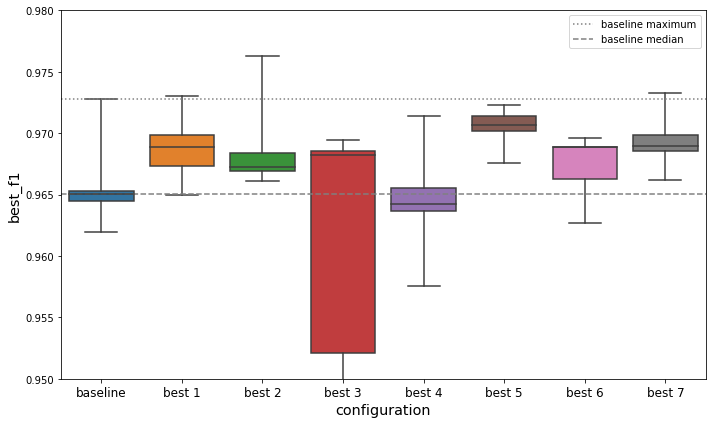

In [73]:
fig = plt.figure(figsize=(10, 6))
sns.boxplot(x='sweep', y='best_f1', data=f1_df, whis=100, order=sorted(f1_df['sweep'].unique()))
plt.ylim([0.95, 0.98])
plt.hlines(0.972772, -0.5, 7.5, linestyles='dotted', color='grey', label='baseline maximum')
plt.hlines(0.965066, -0.5, 7.5, linestyles='dashed', color='grey', label='baseline median')
ax = plt.gca()
l = ax.get_ylabel()
ax.set_ylabel(l, size='x-large')
ax.set_xlabel("configuration", size='x-large')
plt.xticks(fontsize='large')
plt.legend()
#ax.set_xticks([])
fig.tight_layout()

fig.savefig('../figs/glitches/optimized_f1scores.png', dpi=300)

### Create dataloaders and learner from best params

In [4]:
from my_utils import dotdict

In [5]:
best_run_config = dotdict(best_run_config)
experiment_no = best_run_config.experiment_no
best_run_config.inference = True
del best_run_config.experiment_no
experiment_no

4

In [6]:
from wandb_sweep import get_dls, get_learner

In [7]:
dls, image_size, n_channels = get_dls(best_run_config)

In [8]:
learner = get_learner(best_run_config, dls, n_channels)

In [9]:
learner.load(f"{sweep_id}_run{experiment_no}")

### Evaluate model

In [10]:
from model_eval import get_val_preds, plot_CM, plot_CM_PR, plot_top_losses_glitches

In [11]:
preds, targets, soft_preds, y_true, y_pred = get_val_preds(learner)

In [12]:
cm = metrics.confusion_matrix(y_true, y_pred)

In [13]:
acc = metrics.accuracy_score(y_true, y_pred) * 100
f1 = metrics.f1_score(y_true, y_pred, average="macro") * 100
print(f"Overall accuracy: {acc:.2f}%")
print(f"Macro-averaged F1-score: {f1:.2f}%")

Overall accuracy: 99.07%
Macro-averaged F1-score: 97.28%


In [14]:
vocab = list(learner.dls.train_ds.class_dict.keys())

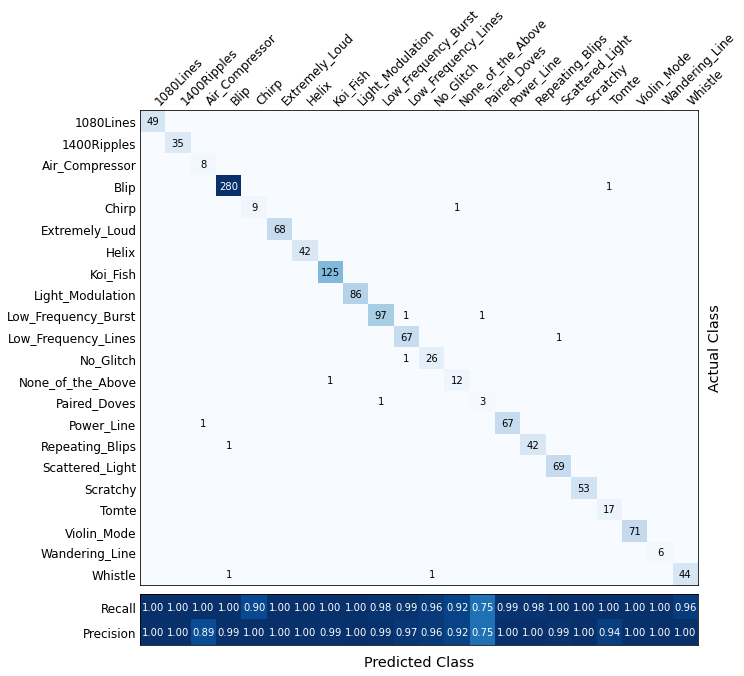

In [237]:
fig, axes = plot_CM_PR(cm, y_true=y_true, y_pred=y_pred, vocab=vocab)
# fig.set_size_inches(10, 10)
fig.savefig("../figs/glitches/baseline_best_cm.png", dpi=300, bbox_inches="tight")

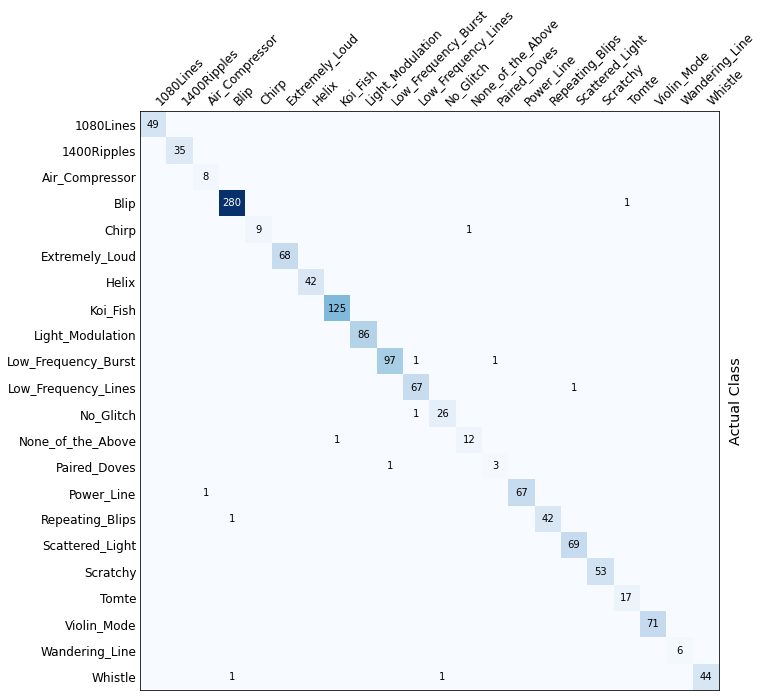

In [203]:
fig1, ax1 = plot_CM(cm, y_true=y_true, y_pred=y_pred, vocab=vocab)
fig1.set_size_inches(10, 10)
# fig.savefig('../figs/glitches/baseline_cm.png', dpi=300)

In [15]:
interp = Interpretation.from_learner(learner)

In [48]:
channel_list = [0, 2, 0, 1, 0, 2, 1, 0, 0, 0, 1, 1]

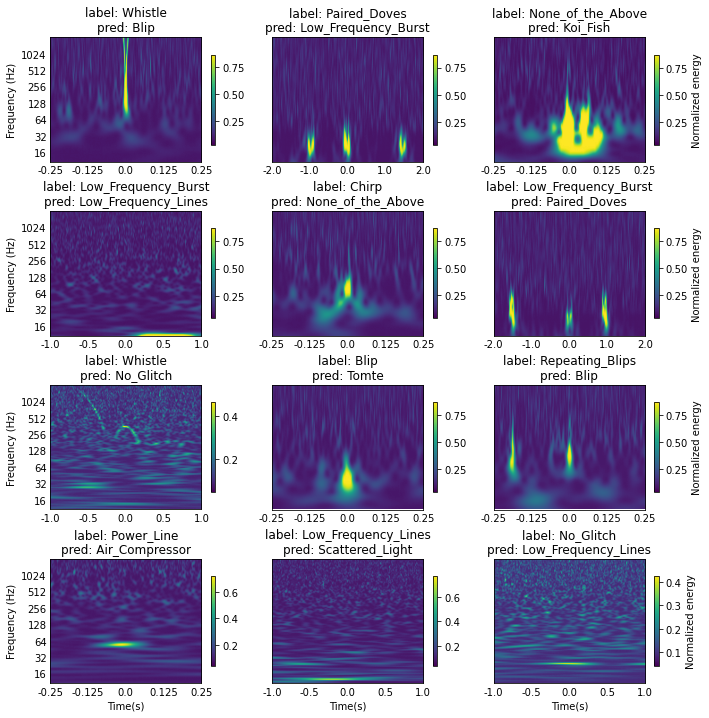

In [49]:
fig, ax = plot_top_losses_glitches(interp, learner, vocab=vocab,
    y_preds=y_pred, channel_list=channel_list,
    largest=True, nrows=4, ncols=3,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(10, 10)
)

fig.savefig('../figs/glitches/baseline_best_mislabeled_samples.png', dpi=300)